<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[0] Mount Google Drive

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# [1] Setting up Environment and Install Requirements

## [1.1] Set Working Directory, Install Requirements

In [ ]:
import os
import sys
import gc
import datetime as dt

# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

In [ ]:
%%capture
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

## [1.2] Load and Initialize the Movie Registration Class

In [ ]:
#Load Libraries Global
import pandas as pd
import numpy as np
import torch
from selenium import webdriver
from bs4 import BeautifulSoup
import re
from IPython.display import display, HTML


# Load Libraries Local
%load_ext autoreload
%reload_ext autoreload

from sources.ChinaFilm.Record_Registration import Registration # assume relative path at path_wd
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',options=chrome_options)
dy_reg = Registration(driver)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## [1.3] Load Latest Registration Publication

In [ ]:
dy_reg.contents_of_registrations_existing

In [ ]:
os.chdir('/content/drive/MyDrive/Github/Content/sources/ChinaFilm')
##########################################
# Use update_first=True to get latest records from China Film's Website
# Wait till dy_reg.contents_of_registrations_existing is fully loaded
df = dy_reg.Refined_Records(dy_reg.contents_of_registrations_existing)
##########################################

# curr_issue_name
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name]

issue_name = df_curr['公示批次起始'].iloc[0][0] + '年' + df_curr['公示批次起始'].iloc[0][1] +'月'
issue_name += df_curr['公示批次起始'].iloc[0][2]
print(issue_name)

2021年7月整月


In [ ]:
df_curr['梗概']

30889    成年的李舒扬继承了已故爸爸的一家海洋救助站。他在里面找到一本爸爸的画册，讲述了少年李于和各种...
30769    本片讲述失踪儿童成年后被找回的故事。过程中经历了亲生父母寻子、养父养母涉嫌贩卖人口，但最终洗...
30737    大学毕业初来乍到的村官张未来，心怀乡村振兴梦的他满腔热情想要重新激发出美丽村的活力，克服重重...
30736    卖面为生的张波夫妇中了一亿彩票，没见过这么多钱的夫妇决定隐瞒此事，在公证处领完钱后决定回老家...
30735    《四郎探母》讲述了北宋时期，杨家为抵抗北方各少数民族的南侵，全家男女老少齐上阵，演绎出了一个...
                               ...                        
30807    小张骑摩托进城，想见自己心仪的女孩，游荡了几天一直没见到人。本想带给她做礼物的一只小羊，误食...
30802    富二代公子杜宏为了摆脱父亲的光环努力的想证明自己，然而却陷入了父亲对手墨白的报复陷阱之中。看...
30805    慕南风为护心爱之人，从而陷入一场，由至尊神皇为了逆天改命所掀起的腥风血雨之中，历经夺神剑，入...
30803    蛟龙盗取定海神珠与三公主龙小念搏斗，神珠坠落凡间医馆。龙小念发现神珠被医馆的大夫叶文修吞下，...
30804    林文峰和他几个爱唱歌的“兄弟”梦想在歌唱大赛里夺冠，虽然他们经历了各种磨难，但他们依然唱出了...
Name: 梗概, Length: 240, dtype: string

## [1.4] Load Title Prediction Model

In [ ]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.to(device)
model.eval()

In [ ]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
L = df_curr.shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [ ]:
df_curr['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df_curr['预测片名'] = df_curr['预测片名'].apply(remove_specials)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_curr['预测片名']

30889      海洋救助站
30769      童年的秘密
30737         村晚
30736       一亿彩票
30735       四郎探母
          ...   
30807    小张骑摩托进城
30802    我的父亲是警察
30805        夺神剑
30803       定海神珠
30804       青春之歌
Name: 预测片名, Length: 240, dtype: object

## [1.5] Genre Classifier

In [ ]:
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset
from transformers import TrainingArguments, Trainer

In [ ]:
path_wd = '/content/drive/MyDrive/Github/Content'
path_NRTA = '/content/drive/MyDrive/Github/Content/sources/NRTA'

In [ ]:
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
id2label_time = {}
for k, v in label2id_time.items(): id2label_time[v] = k


label2id_genre= {'传奇': 0, '传记': 1, '其它': 2, '军旅': 3, '农村': 4, '宫廷': 5,  
                  '武打': 6, '涉案': 7, '神话': 8, '科幻': 9, '都市': 10, '青少': 11,
                  '革命': 12}
id2label_genre = {}
for k, v in label2id_genre.items(): id2label_genre[v] = k


In [ ]:
%%capture
# Genre Classifier
N_LABELS = len(id2label_genre)
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_curr.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_curr['类型'] = test_predictions
df_curr['类型'] = df_curr['类型'].apply(lambda x: id2label_genre[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## [1.6] Time Period Classifier

In [ ]:
%%capture
# Time Classifier

N_LABELS = len(id2label_time)
ID2LABEL = id2label_time
LABEL2ID = label2id_time

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAtime'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_curr.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_curr['年代'] = test_predictions
df_curr['年代'] = df_curr['年代'].apply(lambda x: id2label_time[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# [2] Generating Article Contents

##[2.1] XXXX年XX月电影备案公示划重点

In [ ]:
# Title
T1 = '{year}年'.format(year=df_curr.iloc[0]['公示批次起始'][0])
T1 += '{month}月'.format(month=df_curr.iloc[0]['公示批次起始'][1])
if df_curr.iloc[0]['公示批次起始'][2] != '整月':
  T1 += '{duration}'.format(duration=df_curr.iloc[0]['公示批次起始'][2])
T1 += '电影备案公示划重点'
print(T1)

2021年7月电影备案公示划重点


##[2.2] 	XXXX年XX月XX日,XX月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《熊猫传奇——黑洞之吻》,备案号为影特备字〔2021〕第006号,最近期的项目是《幕后英雄》,备案号为影剧备字〔2021〕第1360号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


In [ ]:
# Obtain Variables
df_curr.loc[:,'公示日期'] = df_curr.loc[:,'公示日期'].astype('datetime64')
pub_year = df_curr.iloc[0]['公示日期'].year
pub_month = df_curr.iloc[0]['公示日期'].month
pub_day = df_curr.iloc[0]['公示日期'].day
df_curr['备案申请年份'] = df_curr['备案申请年份'].astype('int')
df_curr_sorted = df_curr.sort_values(
    ['备案申请年份', '备案立项年度顺序号'], ascending=True
).reset_index(drop=True)
df_type = df_curr.groupby('电影类别')['电影类别'].count().sort_values(
    ascending=False).rename('数量').to_frame().reset_index()

# Write Content
T2 = '\t'
T2 += '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
T2 += '{month}月{part_of_month}的备案公示新鲜出炉！'.format(
    month=df_curr.iloc[0]['公示批次起始'][1], part_of_month=df_curr.iloc[0]['公示批次起始'][2])
T2 += '这一批次中，最遥远的项目是《{}》，'.format(df_curr_sorted.loc[0, '片名']) 
T2 += '备案号为{}，'.format(df_curr_sorted.loc[0, '备案立项号'])
T2 += '最近期的项目是《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
T2 += '备案号为{}。'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'])
T2 += '按备案类别划分本次完成备案的共计'
for i, row in df_type.iterrows():
  if i == df_type.shape[0]-1:
    T2 = T2.rstrip('、')
    T2 += '以及{type}{n}部。'.format(type=row['电影类别'], n=row['数量'])
  else:
    T2 += '{type}{n}部、'.format(type=row['电影类别'], n=row['数量'])
print(T2)

	2021年9月7日，7月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《加油吧！乡亲们》，备案号为影纪备字〔2021〕第971号，最近期的项目是《记忆裂缝》，备案号为影剧备字〔2021〕第2383号。按备案类别划分本次完成备案的共计故事片228部以及纪录片12部。


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## [2.3] 按类型划分，都市题材最多。

In [ ]:
T3 = '\t'
T3 = '按类型划分，都市题材最多,'
df_genre_sorted = df_curr.groupby('类型')['片名'].count().sort_values(ascending=False).reset_index()
df_genre_sorted.columns = ['类型', '数量']

T3 += '共计{}部。'.format(df_genre_sorted['数量'][0])

print(T3)

按类型划分，都市题材最多,共计125部。


##[2.4] 按年代划分，当代题材占主力位置。

In [ ]:
T4 = '\t'
T4 = '按年代划分，当代题材占主力位置,'
df_time_sorted = df_curr.groupby('年代')['片名'].count().sort_values(ascending=False).reset_index()
df_time_sorted.columns = ['年代', '数量']

T4 += '共计{}部。'.format(df_time_sorted['数量'][0])
print(T4)

按年代划分，当代题材占主力位置,共计179部。


##[2.5] 	本批次中，大数据分析识别出XX部上市影视公司关联项目，占比XX%。慷田AI聚焦关注的有

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_curr.loc[df_curr['备案单位'].str.contains(pat_public), ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
df_focus

,电影类别,片名,备案单位,编剧,梗概,备案地
30714,故事片,我的一级兄弟,浙江华策影视股份有限公司,田博,电影讲述了身体残疾的哥哥和智力有缺陷的弟弟，两个没有血缘却胜似亲人的两兄弟相互扶持相互照顾的...,浙江省
30742,故事片,人生整理师,上海儒意影视制作有限公司,杨爽,我们是遗物整理师，有人离开了，就是我们工作开始的时候。 有人会觉得我们的工作没有必要，亲人们...,上海市
30667,故事片,纳帕海的奇迹,西安乐恒昇影视文化传媒有限公司、西安华盛亦泰创意文化传播有限公司、嘉德明诚（北京）文化科技有限公司,史迪可,十二岁的藏族男孩诺布因为救了一匹被遗弃的重伤赛马，增加了失业父亲的生存危机，父子俩一起放蜜蜂...,陕西省
30685,故事片,她的小梨涡,青春光线(扬州)影业有限公司、五光十色（扬州）影业有限公司,孙凯琳,南方来的转学生许呦在来到临城一中的第一天就遇到了桀骜不驯的校霸谢辞，因为一系列的误会和巧合，...,江苏省
30873,故事片,非常之旅,中视音画（福州）传媒有限公司、北京盛世肯特文化传媒有限公司、齐齐哈尔市神鹤影视文化传媒有限责...,肖旭驰、祁媛,“不靠谱”青年李东，酒后把发给朋友的关于加班的吐槽消息误发到了公司群。他一直暗恋的美女钟雅慧...,福建省
30868,故事片,永远的爱,厦门金逸传媒有限公司、北京金逸嘉逸电影发行有限公司,吴玺辰,雯雯原本严厉的母亲近来对自己极为溺爱，直到母亲突然晕倒才得知她得了绝症。为了完成母亲的心愿，...,福建省
30829,故事片,马鞍墙下茉莉香,福州市祥蚨泰禾传媒有限责任公司,田德强,俄罗斯女孩尤丽娅身患绝症，为完成父亲遗作来到福州，在三坊七巷邂逅出身中医世家的李赫。李赫帮助...,福建省
30782,故事片,人间告白,万达影视传媒有限公司,易帅婕、詹晨,小锦和小忽的爱情从他们的17岁开始，一直到小忽离开人间，他们的爱情仍没有结束。她知道还有另一...,北京市
30810,故事片,这么多年,北京光线影业有限公司,赵君莉,出身贫寒的女孩陈见夏进入省重点中学刻苦求学，认识了李燃。陈见夏的愿望是考上大学，李燃的关心给...,北京市


In [ ]:
pat_public

'中广|欢瑞|文投|苏宁|中视|吉视|吉翔|广厦|横店|中原|上海电影|大晟文化|泰禾|京西文化|北京文化|华数|中南|泛海|瀚叶|时代出版|世茂|中国电影|中影,|浙文|鹿港|东方明珠|当代文体|当代明诚|明诚|江苏有线|喜临门|当代|当代东方|电广传媒|湖南电广|祥源文化|祥源|皇氏|鼎龙|美盛|围海|宇顺|慈文|凯撒|中化岩土|中南|中南红|珠江|万达|浙富|国星|金逸|共达|同洲|奥飞|德力|思美|完美|东网|天威|华录百纳|华录|百纳|川网|华谊|新媒|捷成|中文在线|幸福蓝海|新文化|富春|亿通|唐德|浩洋|华策|数码视讯|平治|芒果|芒果超媒|丝路视觉|光线|台基|博汇|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'

In [ ]:
ids = [30714, 30742, 30685, 30868, 30782, 30810]
df_curr['focus'] = False
df_curr.loc[ids, 'focus'] = True
df_focus_narrowed = df_curr.loc[ids, ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地', '类型', '年代', '预测片名']]
#ls_ptitles = []
#for content in df_focus_narrowed['梗概'].tolist():
#    ls_ptitles.append(''.join(autotitle.generate(content,1)).lower())
#ls_ptitles =  ['夺命主持', '北斗传说', '夺命命令', '舞动吧！少年', '妈妈再爱我一次']
#print(ls_ptitles)
########
T5 = '\t'
T5 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
T5 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
T5 += '结合题材与出品方实力，慷田AI聚焦关注'


for _, row in df_focus_narrowed.iterrows():
  T5 += '《{}》'.format(row['片名'])
  T5 += '、'
  #T5 += '\n编剧：{writer}'.format(writer=row['编剧'])
  #T5 += '\n备案单位：{co}'.format(co=row['备案单位'])
  #T5 += '\n{synopsis}\n'.format(synopsis=row['梗概'])

T5 = T5.rstrip('、')
T5 += '，题材覆盖{}'.format('、'.join(df_focus_narrowed['类型'].unique()))

T5 += '。'

print(T5)

	本批次中，大数据分析识别出9部上市影视公司关联项目，占比3.75%。结合题材与出品方实力，慷田AI聚焦关注《我的一级兄弟》、《人生整理师》、《她的小梨涡》、《永远的爱》、《人间告白》、《这么多年》，题材覆盖都市、青少。


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


##[2.6] 生成词云图
 Create Summary Word Cloud ImageImage

In [ ]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

def generate_word_image(ls_words, img_name):
  path_genre_icon = path_img + '/genre_icon/{}'.format(img_name)
  path_mask_image = path_img + '/genre_icon/mask_{}'.format(img_name)
  path_color_image = path_img + '/genre_icon/{}'.format(img_name)

  #wordcloud.color_from_image(coloring)
  mask = np.array(Image.open(path_mask_image)) # 定义词频背景
  coloring = np.array(Image.open(path_color_image)) # Load Image for coloring
  image_colors = wordcloud.ImageColorGenerator(coloring, default_color=(79, 46, 47))
  #image_colors = wordcloud.ImageColorGenerator(coloring)
  #wc.recolor(color_func=image_colors,  random_state=3)

  wc = wordcloud.WordCloud(
      font_path=path_font,
      width = 400,
      height = 100,
      scale = 1,
      mask=mask, # set back ground mask image
      max_words=188,
      max_font_size=244,
      min_font_size=4,
      mode="RGBA",
      #mode="RGB",
      #background_color=None, 
      background_color="rgba(255, 255, 255, 0)", 
      #contour_width=3, 
      #contour_color='steelblue',
      repeat=True,
      color_func=image_colors,
  )
  wc.generate(','.join(ls_words))


  plt.imshow(wc) # 显示词云
  plt.axis('off') # 关闭坐标轴
  plt.show()

  fp_generated_img = path_img + '/ChinaFilm_NewReleases_Overview_'  \
             + img_name.split('.')[0] + '_' + issue_name + '.png'
  wc.to_file(fp_generated_img)

  return fp_generated_img


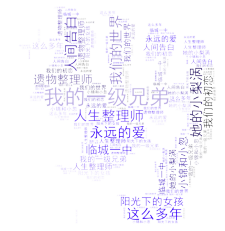

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
ls = df_focus_narrowed['片名'].to_list() + df_focus_narrowed['预测片名'].to_list()
fp_generated_img = generate_word_image(ls, 'fistsq.png')
df_curr['img'] = fp_generated_img

##[2.7] 生成摘要
2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。

In [ ]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['备案单位'].str.extract('('+ pat_public + ")")
df_f = df_focus_narrowed.groupby('单位简称')['片名'].apply(
    lambda x: '、'.join('《' + x + '》')).rename('关注影片').reset_index()
#####
S0 = '{year}年{month}月{day}日，'.format(
    year=pub_year, month=pub_month, day=pub_day)

S0 +=  '{month}月'.format(month=df_curr.iloc[0]['公示批次起始'][1])
if df_curr.iloc[0]['公示批次起始'][2] != '整月':
  S0 += '{duration}'.format(duration=df_curr.iloc[0]['公示批次起始'][2])

S0 += '的电影备案公示发布，其中'
S0 += '最遥远的是{}的《{}》，'.format(
    df_curr_sorted.loc[0, '备案立项号'], df_curr_sorted.loc[0, '片名'])
S0 += '最近期的是{}的《{}》，'.format(
    df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'], 
    df_curr_sorted.loc[df_curr.shape[0]-1, '片名']
)

S0 += '慷田AI聚焦关注的项目有'
for i, row in df_f.iterrows():
  if i == df_f.shape[0]-1:
    S0 = S0.rstrip('、')
    S0 += '以及{co}的{film}'.format(co=row['单位简称'], film=row['关注影片'])
  else:
    S0 += '{co}的{film}、'.format(co=row['单位简称'], film=row['关注影片'])
S0 += '。'

print(S0)

2021年9月7日，7月的电影备案公示发布，其中最遥远的是影纪备字〔2021〕第971号的《加油吧！乡亲们》，最近期的是影剧备字〔2021〕第2383号的《记忆裂缝》，慷田AI聚焦关注的项目有万达的《人间告白》、儒意的《人生整理师》、光线的《她的小梨涡》、《这么多年》、华策的《我的一级兄弟》以及金逸的《永远的爱》。


##[2.8] 指向电影剧官网


In [ ]:
#####
T6 = '\n\n'
T6 += '\t慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
T6 += '电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址 '
T6 += ' http://www.chinafilm.gov.cn/chinafilm 。'

print(T6)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。


## [2.9] Save or load df_{issue_name}

In [ ]:
df_curr

In [ ]:
# Save records for current reg issue
path_records = '/content/drive/MyDrive/Github/Content/tools/articles/records'
df_curr.to_pickle(path_records + '/df_reg_{}.pkl'.format(issue_name))

In [ ]:
#df_curr.read_pickle(path_records + '/df_reg_{}.pkl'.format(issue_name))

#[3] Output Word Document

## 3.1 Install and Load Libraries

In [ ]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

     |████████████████████████████████| 5.6 MB 5.5 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184508 sha256=536be5fad34905ca9b1994a1f565ed39871c119a0f846bfca8a2c989ea7fe95b
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


## 3.2 Output Docx


In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'

doc = Document()
doc.core_properties.title = 'China Movie Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)

doc.add_paragraph(T3)
table_genre = doc.add_table(rows=1, cols=2, style='Light List Accent 4')
for _, row in df_genre_sorted.iterrows():
  row_cells = table_genre.add_row().cells
  row_cells[0].text = row['类型']
  row_cells[1].text = str(row['数量'])


doc.add_paragraph(T4)
table_time = doc.add_table(rows=1, cols=2, style='Light List Accent 4')
for _, row in df_time_sorted.iterrows():
  row_cells = table_time.add_row().cells
  row_cells[0].text = row['年代']
  row_cells[1].text = str(row['数量'])

doc.add_paragraph(T5)

doc.add_picture(fp_generated_img, width =Inches(3))


table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = '类型:{}  年代:{}'.format(row['类型'], row['年代'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(T6)

doc.save(path_doc + '/overview_' + issue_name + '.docx' )
